In [1]:
import pandas as pd
import re
import string
import nltk
import unidecode
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import xgboost
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import random
from sklearn.model_selection import RandomizedSearchCV
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error,mean_squared_error,make_scorer
from sklearn.linear_model import LinearRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from collections import Counter
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("datasets/sentiment_train.csv")

In [16]:
print(df.head())
df.shape

                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1


(2400, 2)

In [125]:
df.isna().sum()

Sentence    0
Polarity    0
dtype: int64

In [5]:
#checking for blank spaces
blanks=[]
for index,Sentence,Polarity in df.itertuples():
    if type(Sentence)==str:
        if Sentence.isspace():
            blanks.append(index)

In [6]:
blanks #no blanks

[]

In [7]:
#checking distribution in target feature.No imbalance
df['Polarity'].value_counts()/len(df)

0    0.505417
1    0.494583
Name: Polarity, dtype: float64

In [75]:
for rows in df["Sentence"]: 
    if re.findall(r'\#NAME',rows):
        print(rows)

#NAME?
#NAME?
#NAME?
#NAME?


In [167]:
#removing those useless columns that Excel marked as #NAME?
df.drop(df[df["Sentence"]=="#NAME?"].index, inplace = True)

In [127]:
df.shape

(2396, 2)

In [20]:
df[df["Sentence"]=="#NAME?"]

,Sentence,Polarity


# Feature engineering

In [168]:
#maybe positive reviews are longer in length
df["Sentence_len"]=df["Sentence"].apply(lambda x:len(x)-x.count(" ")) #removing white spaces from being counted
df.head()

,Sentence,Polarity,Sentence_len
0,Wow... Loved this place.,1,21
1,Crust is not good.,0,15
2,Not tasty and the texture was just nasty.,0,34
3,Stopped by during the late May bank holiday of...,1,73
4,The selection on the menu was great and so wer...,1,48


In [202]:
df.shape

(2396, 5)

In [169]:
import textstat
#easy readability scores
df['flesch_reading_ease']=df['Sentence'].apply(textstat.flesch_reading_ease)
df['automated_readability']=df['Sentence'].apply(textstat.automated_readability_index)

In [79]:
df.head()

,Sentence,Polarity,Sentence_len,flesch_reading_ease,automated_readability
0,Wow... Loved this place.,1,21,118.18,5.3
1,Crust is not good.,0,15,118.18,-1.9
2,Not tasty and the texture was just nasty.,0,34,105.66,2.6
3,Stopped by during the late May bank holiday of...,1,73,64.71,9.0
4,The selection on the menu was great and so wer...,1,48,93.14,3.4


In [170]:
#found % of words that are capitalized thinking maybe positive reviews have more often capitalization
def count_capitalized(text):
    count=sum([1 for char in text if char.isupper()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df["Sentence_capitalized"]=df["Sentence"].apply(lambda x:count_capitalized(x))  
df.head()

,Sentence,Polarity,Sentence_len,flesch_reading_ease,automated_readability,Sentence_capitalized
0,Wow... Loved this place.,1,21,118.18,5.3,9.5
1,Crust is not good.,0,15,118.18,-1.9,6.7
2,Not tasty and the texture was just nasty.,0,34,105.66,2.6,2.9
3,Stopped by during the late May bank holiday of...,1,73,64.71,9.0,5.5
4,The selection on the menu was great and so wer...,1,48,93.14,3.4,2.1


In [171]:
#% of messages that contain digits
def count_digit(text):
    count=sum([1 for char in text if char.isdigit()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df["Sentence_digit"]=df["Sentence"].apply(lambda x:count_digit(x))  
df.head()

,Sentence,Polarity,Sentence_len,flesch_reading_ease,automated_readability,Sentence_capitalized,Sentence_digit
0,Wow... Loved this place.,1,21,118.18,5.3,9.5,0.0
1,Crust is not good.,0,15,118.18,-1.9,6.7,0.0
2,Not tasty and the texture was just nasty.,0,34,105.66,2.6,2.9,0.0
3,Stopped by during the late May bank holiday of...,1,73,64.71,9.0,5.5,0.0
4,The selection on the menu was great and so wer...,1,48,93.14,3.4,2.1,0.0


In [172]:
sid=SentimentIntensityAnalyzer()

#adding a column with compound scores produced by VADER
df['sentiment_compound']=df['Sentence'].apply(lambda r:sid.polarity_scores(r)["compound"])
df.head()

,Sentence,Polarity,Sentence_len,flesch_reading_ease,automated_readability,Sentence_capitalized,Sentence_digit,sentiment_compound
0,Wow... Loved this place.,1,21,118.18,5.3,9.5,0.0,0.5994
1,Crust is not good.,0,15,118.18,-1.9,6.7,0.0,-0.3412
2,Not tasty and the texture was just nasty.,0,34,105.66,2.6,2.9,0.0,-0.5574
3,Stopped by during the late May bank holiday of...,1,73,64.71,9.0,5.5,0.0,0.6908
4,The selection on the menu was great and so wer...,1,48,93.14,3.4,2.1,0.0,0.6249


In [173]:
def score_classifier(row):
    if row>0:
        return 'positive'
    elif row<0:
        return 'negative'
    else:
        return 'neutral'
df['sentiment']=df['sentiment_compound'].apply(score_classifier)
df.head()

,Sentence,Polarity,Sentence_len,flesch_reading_ease,automated_readability,Sentence_capitalized,Sentence_digit,sentiment_compound,sentiment
0,Wow... Loved this place.,1,21,118.18,5.3,9.5,0.0,0.5994,positive
1,Crust is not good.,0,15,118.18,-1.9,6.7,0.0,-0.3412,negative
2,Not tasty and the texture was just nasty.,0,34,105.66,2.6,2.9,0.0,-0.5574,negative
3,Stopped by during the late May bank holiday of...,1,73,64.71,9.0,5.5,0.0,0.6908,positive
4,The selection on the menu was great and so wer...,1,48,93.14,3.4,2.1,0.0,0.6249,positive


In [174]:
#mapping sentiment to 0 or 1 since 1 is >0 in this case
df['sentiment_mapped']=df['sentiment'].map({'positive': 1, 'negative': -1,'neutral':0})
df.head()

,Sentence,Polarity,Sentence_len,flesch_reading_ease,automated_readability,Sentence_capitalized,Sentence_digit,sentiment_compound,sentiment,sentiment_mapped
0,Wow... Loved this place.,1,21,118.18,5.3,9.5,0.0,0.5994,positive,1
1,Crust is not good.,0,15,118.18,-1.9,6.7,0.0,-0.3412,negative,-1
2,Not tasty and the texture was just nasty.,0,34,105.66,2.6,2.9,0.0,-0.5574,negative,-1
3,Stopped by during the late May bank holiday of...,1,73,64.71,9.0,5.5,0.0,0.6908,positive,1
4,The selection on the menu was great and so wer...,1,48,93.14,3.4,2.1,0.0,0.6249,positive,1


In [175]:
#dropping value of sentiment_compound,keeping sentiment only
df.drop(["sentiment_compound","sentiment"],axis=1,inplace=True)

In [86]:
df.head()

,Sentence,Polarity,Sentence_len,flesch_reading_ease,automated_readability,Sentence_capitalized,Sentence_digit,sentiment_mapped
0,Wow... Loved this place.,1,21,118.18,5.3,9.5,0.0,1
1,Crust is not good.,0,15,118.18,-1.9,6.7,0.0,-1
2,Not tasty and the texture was just nasty.,0,34,105.66,2.6,2.9,0.0,-1
3,Stopped by during the late May bank holiday of...,1,73,64.71,9.0,5.5,0.0,1
4,The selection on the menu was great and so wer...,1,48,93.14,3.4,2.1,0.0,1


In [87]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

(array([0.        , 0.00129032, 0.01225806, 0.01967742, 0.01274194,
        0.01532258, 0.01370968, 0.01532258, 0.01193548, 0.01145161,
        0.01032258, 0.0116129 , 0.00774194, 0.00677419, 0.00645161,
        0.00725806, 0.00612903, 0.00532258, 0.00387097, 0.00306452,
        0.00322581, 0.00209677, 0.00241935, 0.00258065, 0.00048387,
        0.        , 0.00016129, 0.        , 0.00032258, 0.00016129,
        0.00048387, 0.        , 0.00016129, 0.00032258, 0.00016129,
        0.        , 0.        , 0.        , 0.00016129]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.589743

(array([0.        , 0.00280694, 0.01221846, 0.01816257, 0.0161812 ,
        0.01981372, 0.01287892, 0.01535563, 0.01205334, 0.01304403,
        0.0092464 , 0.00776037, 0.00792549, 0.00792549, 0.00776037,
        0.00544877, 0.00511854, 0.00445809, 0.00379763, 0.00247671,
        0.00181626, 0.00297206, 0.00181626, 0.00181626, 0.00066046,
        0.        , 0.00033023, 0.00016511, 0.00016511, 0.00033023,
        0.        , 0.        , 0.00016511, 0.        , 0.        ,
        0.        , 0.00033023, 0.        , 0.        ]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.589743

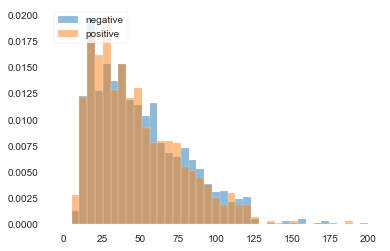

In [88]:
#the distribution is almost the same, doesn't seem to be a particularly useful feature
bins=np.linspace(0,200,40)

pyplot.hist(df[df['Polarity']==0]['Sentence_len'], bins, alpha=0.5, density=True, label='negative')
pyplot.hist(df[df['Polarity']==1]['Sentence_len'], bins, alpha=0.5, density=True, label='positive')
pyplot.legend(loc='upper left')
pyplot.show()

(array([0.14073493, 0.03864575, 0.00531379, 0.00386457, 0.00161024,
        0.00080512, 0.00016102, 0.        , 0.        , 0.00032205,
        0.00048307, 0.        , 0.        , 0.        , 0.00048307,
        0.00016102, 0.00016102, 0.0006441 , 0.00112717, 0.00048307,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.589743

(array([0.13658228, 0.04327848, 0.00691139, 0.00329114, 0.0023038 ,
        0.00032911, 0.00049367, 0.00049367, 0.        , 0.        ,
        0.        , 0.        , 0.00016456, 0.00016456, 0.        ,
        0.00049367, 0.00016456, 0.00016456, 0.00016456, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.589743

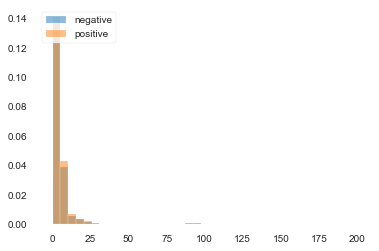

In [50]:
#the distribution is almost the same, doesn't seem to be a particularly useful feature
bins=np.linspace(0,200,40) 

pyplot.hist(df[df['Polarity']==0]['Sentence_capitalized'], bins, alpha=0.5, density=True, label='negative')
pyplot.hist(df[df['Polarity']==1]['Sentence_capitalized'], bins, alpha=0.5, density=True, label='positive')
pyplot.legend(loc='upper left')
pyplot.show()

(array([0.        , 0.00099574, 0.00016596, 0.0011617 , 0.00082979,
        0.00132766, 0.0089617 , 0.00265532, 0.00265532, 0.00979149,
        0.00514468, 0.01161702, 0.01128511, 0.01642979, 0.01842128,
        0.02091064, 0.01460426, 0.01759149, 0.01725957, 0.01211489,
        0.0078    , 0.00182553, 0.00580851, 0.00564255, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.589743

(array([0.00033534, 0.00134136, 0.00067068, 0.00117369, 0.00083835,
        0.00150903, 0.00771281, 0.00234738, 0.00251505, 0.0088865 ,
        0.00503009, 0.01123388, 0.01374893, 0.01039553, 0.0194497 ,
        0.01810834, 0.02095873, 0.01542562, 0.01559329, 0.0088865 ,
        0.00821582, 0.00150903, 0.00670679, 0.01240757, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.589743

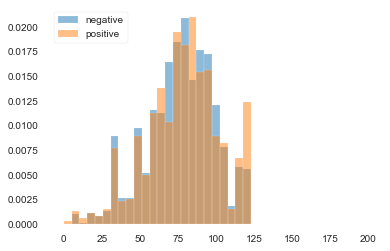

In [90]:
#negative polarity has a bit higher readability scores
bins=np.linspace(0,200,40)

pyplot.hist(df[df['Polarity']==0]['flesch_reading_ease'], bins, alpha=0.5, density=True, label='negative')
pyplot.hist(df[df['Polarity']==1]['flesch_reading_ease'], bins, alpha=0.5, density=True, label='positive')
pyplot.legend(loc='upper left')
pyplot.show()

(array([1.91940545e-01, 2.09331131e-03, 8.05119736e-04, 1.61023947e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  9

(array([1.91379747e-01, 2.63291139e-03, 4.93670886e-04, 3.29113924e-04,
        0.00000000e+00, 0.00000000e+00, 1.64556962e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  9

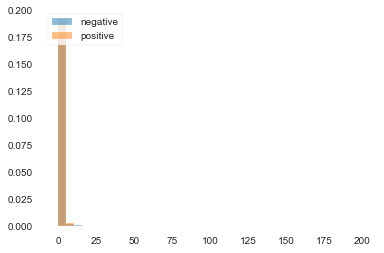

In [91]:
#the distribution is almost the same, doesn't seem to be a particularly useful feature
bins=np.linspace(0,200,40)

pyplot.hist(df[df['Polarity']==0]['Sentence_digit'], bins, alpha=0.5, density=True, label='negative')
pyplot.hist(df[df['Polarity']==1]['Sentence_digit'], bins, alpha=0.5, density=True, label='positive')
pyplot.legend(loc='upper left')
pyplot.show()

<Figure size 1008x720 with 0 Axes>

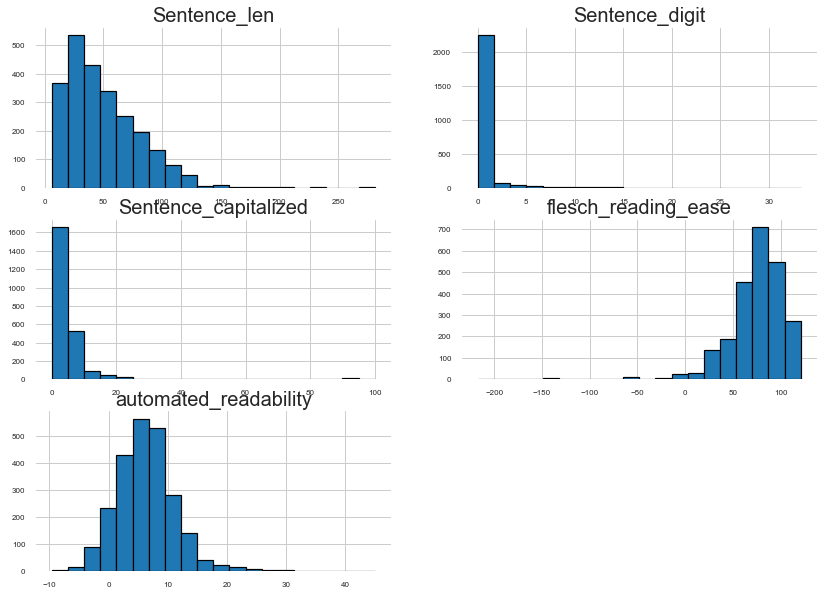

In [92]:
#Checking the shape of numeric features
def plot_hist(ax, feature, title):
    ax.hist(feature, bins=20, edgecolor='black', linewidth=1.2);
    ax.set_title(title, fontsize=20);
    ax.tick_params(axis='both', which='major', labelsize=8);
    ax.grid(True);

plt.figure(figsize=(14, 10));
plt.grid(True);
plot_hist(plt.subplot(3, 2, 1), df['Sentence_len'], 'Sentence_len')
plot_hist(plt.subplot(3, 2, 2), df['Sentence_digit'], 'Sentence_digit')
plot_hist(plt.subplot(3, 2, 3), df['Sentence_capitalized'], 'Sentence_capitalized')
plot_hist(plt.subplot(3, 2, 4), df['flesch_reading_ease'], 'flesch_reading_ease')
plot_hist(plt.subplot(3, 2, 5), df['automated_readability'], 'automated_readability')

In [93]:
#doing preprocessing to plot word cloud
wn=nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_text(text):
        text="".join([char.lower() for char in text if char not in string.punctuation]) 
        text= re.sub(r'\d+', '', text)
        tokens=re.split('\W+', text.strip()) 
        text=[unidecode.unidecode(tokens) for tokens in tokens]
        text=" ".join([wn.lemmatize(word) for word in tokens if word not in stop_words])
        return text

df["Sentence_clean"]=df["Sentence"].apply(lambda x:clean_text(x))

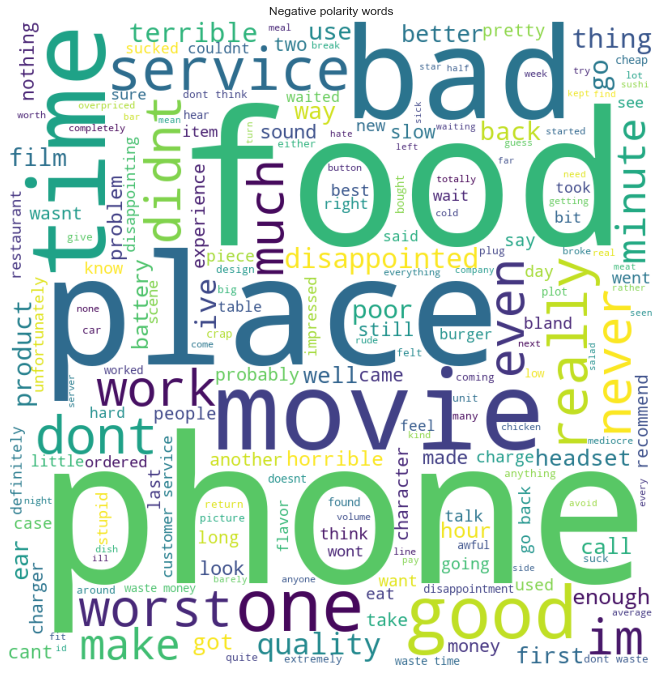

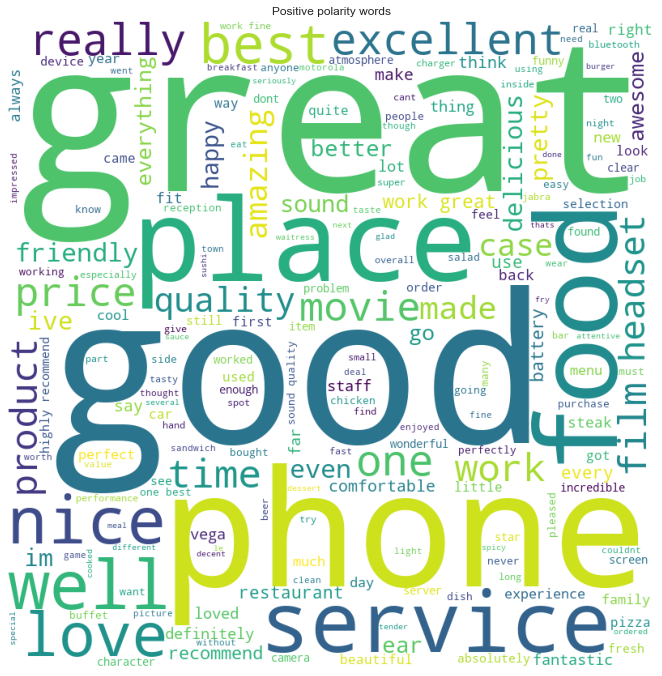

In [94]:
#Checking most popular words in sentences with Polarity 0
all_words_negative=pd.DataFrame(df[df['Polarity']==0]['Sentence_clean'])
all_words_negative = ' '.join(all_words_negative['Sentence_clean'])

#Checking most popular words in sentences with Polarity 1
all_words_positive=pd.DataFrame(df[df['Polarity']==1]['Sentence_clean'])
all_words_positive = ' '.join(all_words_positive['Sentence_clean'])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words_negative)
 
# plot the WordCloud image                       
_=pyplot.figure(figsize = (9, 9), facecolor = None)
_=pyplot.imshow(wordcloud)
_=pyplot.axis("off")
_=pyplot.tight_layout(pad = 0)
_=pyplot.title('Negative polarity words')

pyplot.show()

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words_positive)
 
# plot the WordCloud image                       
_=pyplot.figure(figsize = (9, 9), facecolor = None)
_=pyplot.imshow(wordcloud)
_=pyplot.axis("off")
_=pyplot.tight_layout(pad = 0)
_=pyplot.title('Positive polarity words') 
pyplot.show()

# Data Cleaning

In [176]:
wn=nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_text(text):
        text="".join([char.lower() for char in text if char not in string.punctuation]) 
        text= re.sub(r'\d+', '', text)
        tokens=re.split('\W+', text.strip()) 
        text=[unidecode.unidecode(tokens) for tokens in tokens]
        text=[wn.lemmatize(word) for word in tokens if word not in stop_words]
        return text
    
#After cleaning the data, split into train/test
X = df.drop("Polarity",axis=1)
y = df[['Polarity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [58]:
X_train.head()

,Sentence,flesch_reading_ease,dall_chall_readability,automated_readability,Sentence_capitalized,Sentence_digit,sentiment_mapped,Sentence_len,Sentence_clean
1539,none of the new ones have ever quite worked pr...,86.71,4.3,4.3,0.0,0.0,0,44,none new one ever quite worked properly
1177,"I put the latest OS on it (v1.15g), and it now...",88.40,6.5,6.5,3.7,3.7,1,82,put latest o vg like slow crawl lock every
1406,It's so stupid to have to keep buying new char...,72.50,12.0,12.0,0.9,0.0,-1,109,stupid keep buying new charger car charger cra...
510,"I don't each much pasta, but I love the homema...",88.06,7.0,7.0,2.8,0.0,1,72,dont much pasta love homemade hand made pasta ...
1297,This one works and was priced right.,115.13,2.3,2.3,3.3,0.0,0,30,one work priced right


In [177]:
#Transformation of skewed features
scaler = preprocessing.PowerTransformer(method='yeo-johnson').fit(X_train[['Sentence_len']])
X_train['Sentence_len'] = scaler.transform(X_train[['Sentence_len']])
X_test['Sentence_len'] = scaler.transform(X_test[['Sentence_len']])

scaler2 = preprocessing.PowerTransformer(method='yeo-johnson').fit(X_train[['Sentence_capitalized']])
X_train['Sentence_capitalized'] = scaler2.transform(X_train[['Sentence_capitalized']])
X_test['Sentence_capitalized'] = scaler2.transform(X_test[['Sentence_capitalized']])

scaler3 = preprocessing.PowerTransformer(method='yeo-johnson').fit(X_train[['Sentence_digit']])
X_train['Sentence_digit'] = scaler3.transform(X_train[['Sentence_digit']])
X_test['Sentence_digit'] = scaler3.transform(X_test[['Sentence_digit']])

scaler4 = preprocessing.PowerTransformer(method='yeo-johnson').fit(X_train[['flesch_reading_ease']])
X_train['flesch_reading_ease'] = scaler4.transform(X_train[['flesch_reading_ease']])
X_test['flesch_reading_ease'] = scaler4.transform(X_test[['flesch_reading_ease']])


<Figure size 1008x576 with 0 Axes>

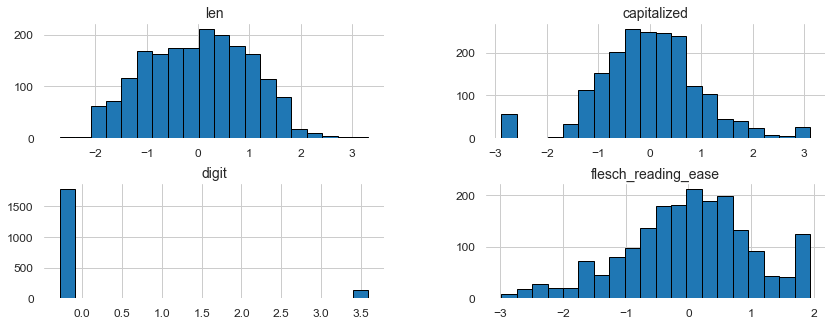

In [117]:
#checking the data after transformations applied
def plot_hist(ax, feature, title):
    ax.hist(feature, bins=20, edgecolor='black', linewidth=1.0);
    ax.set_title(title, fontsize=14);
    ax.tick_params(axis='both', which='major', labelsize=12);
    ax.grid(True);
    plt.subplots_adjust(wspace=0.3,hspace=0.4)

plt.figure(figsize=(14, 8));
plt.tight_layout()
plt.grid(True);
plot_hist(plt.subplot(3, 2, 1), X_train['Sentence_len'], 'len')
plot_hist(plt.subplot(3, 2, 2), X_train['Sentence_capitalized'], 'capitalized')
plot_hist(plt.subplot(3, 2, 3), X_train['Sentence_digit'], 'digit')
plot_hist(plt.subplot(3, 2, 4), X_train['flesch_reading_ease'], 'flesch_reading_ease')

In [118]:
X_train.head()

,Sentence,Sentence_len,flesch_reading_ease,automated_readability,Sentence_capitalized,Sentence_digit,sentiment_mapped,Sentence_clean
1539,none of the new ones have ever quite worked pr...,0.095450,0.407744,4.3,-2.884096,-0.278595,0,none new one ever quite worked properly
1177,"I put the latest OS on it (v1.15g), and it now...",1.125307,0.478935,6.5,0.096669,3.590434,1,put latest o vg like slow crawl lock every
1406,It's so stupid to have to keep buying new char...,1.619480,-0.173336,12.0,-1.476766,-0.278595,-1,stupid keep buying new charger car charger cra...
510,"I don't each much pasta, but I love the homema...",0.904371,0.464578,7.0,-0.234823,-0.278595,1,dont much pasta love homemade hand made pasta ...
1297,This one works and was priced right.,-0.502949,1.657855,2.3,-0.039454,-0.278595,0,one work priced right


# CountVectorizer approach to vecetorize text feature

In [178]:
#CountVectorizer
count_vect=CountVectorizer(analyzer=clean_text)
X_counts_fit=count_vect.fit(X_train["Sentence"])

X_counts_train=X_counts_fit.transform(X_train["Sentence"])
X_counts_test=X_counts_fit.transform(X_test["Sentence"])

In [121]:
#Topic modeling
from sklearn.decomposition import LatentDirichletAllocation

comp_score=list()
for comp in np.arange(1,11):
    lda_model = LatentDirichletAllocation(n_components=comp,
                                          doc_topic_prior=None,
                                          topic_word_prior=None,
                                          max_iter=200, 
                                          learning_method='batch', 
                                          random_state=42,
                                          n_jobs=2,
                                          verbose=0)
    lda_model.fit(X_counts_train)

    lda_model_output_train=pd.DataFrame(lda_model.transform(X_counts_train))

    # Log Likelyhood: Higher the better
    ll = lda_model.score(X_counts_train)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    perp = lda_model.perplexity(X_counts_train)
    
    df_lda_results = pd.DataFrame({"Topics":[comp],
                                   "Log likelyhood":[ll],
                                   "Perplexity":[perp]
                                     })
    comp_score.append(df_lda_results)
    
    dataset_lda_results = pd.concat([m for m in comp_score], axis = 0).reset_index() 
    dataset_lda_results = dataset_lda_results.drop(columns = "index",axis =1)
    dataset_lda_results = dataset_lda_results.sort_values(by=['Log likelyhood'], ascending=False)
    dataset_lda_results['Rank'] = range(1, len(dataset_lda_results)+1)
print(dataset_lda_results)

LatentDirichletAllocation(max_iter=200, n_components=1, n_jobs=2,
                          random_state=42)

LatentDirichletAllocation(max_iter=200, n_components=2, n_jobs=2,
                          random_state=42)

LatentDirichletAllocation(max_iter=200, n_components=3, n_jobs=2,
                          random_state=42)

LatentDirichletAllocation(max_iter=200, n_components=4, n_jobs=2,
                          random_state=42)

LatentDirichletAllocation(max_iter=200, n_components=5, n_jobs=2,
                          random_state=42)

LatentDirichletAllocation(max_iter=200, n_components=6, n_jobs=2,
                          random_state=42)

LatentDirichletAllocation(max_iter=200, n_components=7, n_jobs=2,
                          random_state=42)

LatentDirichletAllocation(max_iter=200, n_components=8, n_jobs=2,
                          random_state=42)

LatentDirichletAllocation(max_iter=200, n_components=9, n_jobs=2,
                          random_state=42)

   Method  Log likelyhood   Perplexity  Rank
0       1   -80437.536811  1765.699722     1
1       2   -81587.438647  1964.868237     2
2       3   -82883.005709  2216.306874     3
3       4   -84219.399935  2509.425872     4
4       5   -85098.383364  2723.047053     5
5       6   -86000.435908  2961.195775     6
6       7   -86473.274048  3094.236893     7
7       8   -86818.275006  3195.065475     8
8       9   -87475.557621  3396.342112     9


In [179]:
#Fitting LDA with 5 topics
lda_model = LatentDirichletAllocation(n_components=5,
                                          doc_topic_prior=None,
                                          topic_word_prior=None,
                                          max_iter=200, 
                                          learning_method='batch', 
                                          random_state=42,
                                          n_jobs=2,
                                          verbose=0)
lda_model.fit(X_counts_train)

lda_model_output_train=pd.DataFrame(lda_model.transform(X_counts_train))
lda_model_output_test=pd.DataFrame(lda_model.transform(X_counts_test))

LatentDirichletAllocation(max_iter=200, n_components=5, n_jobs=2,
                          random_state=42)

In [180]:
#Combining all together before proceeding with classification
X_count_features_train=pd.concat([X_train[['Sentence_len','Sentence_capitalized',"Sentence_digit",
                                    "sentiment_mapped","flesch_reading_ease","automated_readability"]].reset_index(drop=True),
                            pd.DataFrame(X_counts_train.toarray(),columns=count_vect.get_feature_names()),lda_model_output_train], axis=1)

X_count_features_test=pd.concat([X_test[['Sentence_len','Sentence_capitalized',"Sentence_digit",
                                    "sentiment_mapped","flesch_reading_ease","automated_readability"]].reset_index(drop=True),
                            pd.DataFrame(X_counts_test.toarray(),columns=count_vect.get_feature_names()),lda_model_output_test], axis=1)


In [124]:
X_count_features_train.tail()

,Sentence_len,Sentence_capitalized,Sentence_digit,sentiment_mapped,flesch_reading_ease,automated_readability,abhor,ability,able,abound,...,yucky,yukon,yummy,za,zero,0,1,2,3,4
1911,0.706911,-0.882398,-0.278595,-1,-0.438418,7.1,0,0,0,0,...,0,0,0,0,0,0.734477,0.178778,0.029094,0.028623,0.029029
1912,-0.310390,-0.193160,-0.278595,-1,-1.075206,8.3,0,0,0,0,...,0,0,0,0,0,0.798052,0.050646,0.050481,0.050282,0.050538
1913,-0.719477,1.667568,-0.278595,0,0.709641,20.9,0,0,0,0,...,0,0,0,0,0,0.066680,0.066678,0.067820,0.732137,0.066685
1914,-0.662751,0.096669,-0.278595,-1,-1.571469,12.4,0,0,0,0,...,0,0,0,0,0,0.799899,0.050100,0.050000,0.050000,0.050000
1915,-0.554598,-0.003919,-0.278595,1,1.657855,1.6,0,0,0,0,...,0,0,0,0,0,0.540831,0.307219,0.050003,0.050871,0.051076


In [126]:
#Show the top tokens/grams

# Calculate column sums from DTM
sum_words = X_counts_train.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]

words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

# Display top few
words_freq[:20]

[('good', 152),
 ('great', 144),
 ('phone', 135),
 ('food', 93),
 ('place', 92),
 ('service', 86),
 ('time', 82),
 ('one', 77),
 ('work', 75),
 ('like', 74),
 ('movie', 69),
 ('really', 65),
 ('would', 61),
 ('dont', 57),
 ('quality', 55),
 ('go', 54),
 ('back', 53),
 ('best', 53),
 ('get', 53),
 ('film', 52)]

<Figure size 360x576 with 0 Axes>

FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E13BA9370>,
                    features=['abhor', 'ability', 'able', 'abound',
                              'abovepretty', 'absolutel', 'absolutely',
                              'absolutley', 'abstruse', 'ac', 'accept',
                              'acceptable', 'access', 'accessable', 'accessing',
                              'accessory', 'accessoryone', 'accident',
                              'accidentally', 'accommodation', 'accomodate',
                              'according', 'accountant', 'accurately',
                              'accused', 'acted', 'acting', 'actingwise',
                              'action', 'activate', ...],
                    n=None)

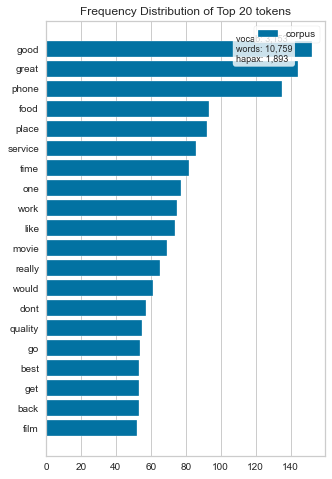

In [127]:
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(5,8))
visualizer = FreqDistVisualizer(features=count_vect.get_feature_names(), n=20)
visualizer.fit(X_counts_train)
visualizer.poof()

In [129]:
import time

lr = LogisticRegression(random_state=42) 
dt = DecisionTreeClassifier(random_state=42)
gb=xgboost.XGBClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, n_estimators=200)
ada = AdaBoostClassifier(random_state=42, n_estimators=200)
svm=SVC(random_state=42,probability=True)

classifiers = {
    "LR": lr, 
    "DT": dt,
    "RF": rf,
    "Adaboost": ada,
    "SVM":svm,
    "GBC": gb
}

model_results = list()
    
for model_name,model in classifiers.items():
    start = time.time()
    fitting=model.fit(X_count_features_train,y_train)
    end = time.time()
    total = end - start
    y_pred=fitting.predict_proba(X_count_features_test)[:,1]
    auc=roc_auc_score(y_test,y_pred)
     
    df_results = pd.DataFrame({"Method": [model_name],
                               "Time" : [total],
                               "AUC" : [auc]
                             })
    model_results.append(df_results)
    
    dataset_results = pd.concat([m for m in model_results], axis = 0).reset_index() 
    dataset_results = dataset_results.drop(columns = "index",axis =1)
    dataset_results = dataset_results.sort_values(by=['AUC'], ascending=False)
    dataset_results['Rank'] = range(1, len(dataset_results)+1)
print(dataset_results)


     Method       Time       AUC  Rank
0        LR   0.739057  0.911142     1
2        RF   6.541495  0.908250     2
4       SVM  47.544133  0.902248     3
5       GBC  14.693113  0.899712     4
3  Adaboost  17.654504  0.866844     5
1        DT   0.936070  0.767250     6


In [130]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3 (0.194211)
2. feature 1192 (0.028460)
3. feature 3159 (0.024605)
4. feature 3162 (0.024297)
5. feature 3163 (0.023528)
6. feature 4 (0.022745)
7. feature 3161 (0.022551)
8. feature 3160 (0.020971)


In [131]:
dataset_results

,Method,Time,AUC,Rank
0,LR,0.739057,0.911142,1
2,RF,6.541495,0.908250,2
4,SVM,47.544133,0.902248,3
5,GBC,14.693113,0.899712,4
3,Adaboost,17.654504,0.866844,5
1,DT,0.936070,0.767250,6


# Hyper-parameter tuning 

In [132]:
c_space=np.logspace(-5,3,8)
param_grid={"C":c_space,
           "max_iter":[200,300,400,500],
           "penalty":["l1","l2","elasticnet","none"],
           "solver":["newton-cg","lbfgs","liblinear","sag"]}

log_clf=GridSearchCV(lr,param_grid,cv=10)
log_cv=log_clf.fit(X_count_features_train,y_train)
log_y_pred=log_cv.predict_proba(X_count_features_test)[:,1]
auc_log=roc_auc_score(y_test,log_y_pred)

In [136]:
log_cv.best_estimator_

LogisticRegression(C=5.179474679231202, max_iter=200, penalty='l1',
                   random_state=42, solver='liblinear')

In [137]:
auc_list={}
auc_list['log_reg']=auc_log

In [148]:
auc_list

{'log_reg': 0.9018310054895421}

Precision score:0.8471615720524017
Recall score:0.8290598290598291


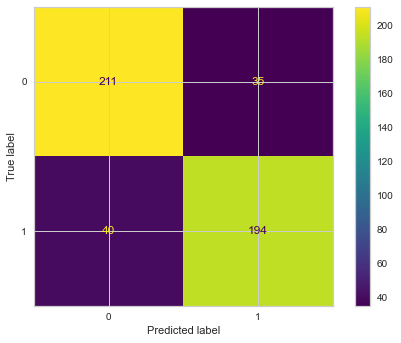

In [147]:
log_y_pred_=log_cv.predict(X_count_features_test)
print('Precision score:{}'.format(precision_score(y_test,log_y_pred_)))
print('Recall score:{}'.format(recall_score(y_test,log_y_pred_)))
plot_confusion_matrix(log_clf, X_count_features_test, y_test)

In [181]:
rf=RandomForestClassifier(random_state=42)

parameters={"min_samples_leaf":[1,3,5,10],
            "max_depth":[10,15,20,25,30],
             "max_features":[1,5,15,20,17],
            "n_estimators":[100,200,300,350,400],
             "criterion":["gini","entropy"]}

rf_cv=GridSearchCV(rf,param_grid=parameters,cv=10)
rf_cv=rf_cv.fit(X_count_features_train,y_train)
rf_y_pred=rf_cv.predict_proba(X_count_features_test)[:,1]
auc_rf=roc_auc_score(y_test,y_pred)

auc_list['rf']=auc_rf
auc_list

{'log_reg': 0.9018310054895421, 'rf': 0.8997116253213815}

In [182]:
rf_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 5,
 'min_samples_leaf': 1,
 'n_estimators': 350}

Precision score:0.8471615720524017
Recall score:0.8290598290598291


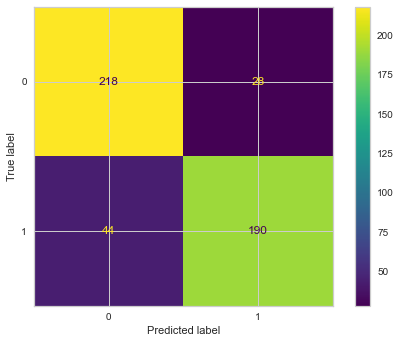

In [185]:
rf_y_pred_=log_cv.predict(X_count_features_test)
print('Precision score:{}'.format(precision_score(y_test,rf_y_pred_)))
print('Recall score:{}'.format(recall_score(y_test,rf_y_pred_)))
plot_confusion_matrix(rf_cv, X_count_features_test, y_test)

# TF-IDF vectorization approach

In [186]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text,max_df=0.8,min_df=0.02,ngram_range=[1,2])
X_tfidf = tfidf_vect.fit(X_train["Sentence"])

X_tfidf_train=X_tfidf.transform(X_train["Sentence"])
X_tfidf_test=X_tfidf.transform(X_test["Sentence"])

In [187]:
#Topic modeling
from sklearn.decomposition import LatentDirichletAllocation

lda_model_tfidf = LatentDirichletAllocation(n_components=5,
                                      doc_topic_prior=None,
                                      topic_word_prior=None,
                                      max_iter=200, 
                                      learning_method='batch', 
                                      random_state=42,
                                      n_jobs=2,
                                      verbose=0)
lda_model_tfidf.fit(X_tfidf_train)

lda_model_tfidf_output_train=pd.DataFrame(lda_model_tfidf.transform(X_tfidf_train))
lda_model_tfidf_output_test=pd.DataFrame(lda_model_tfidf.transform(X_tfidf_test))

# Log Likelyhood: Higher the better
ll = lda_model_tfidf.score(X_tfidf_train)

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
perp = lda_model_tfidf.perplexity(X_tfidf_train)

LatentDirichletAllocation(max_iter=200, n_components=5, n_jobs=2,
                          random_state=42)

In [188]:
X_tfidf_features_train =pd.concat([X_train[['Sentence_len','Sentence_capitalized',"Sentence_digit",
                                    "sentiment_mapped","flesch_reading_ease","automated_readability"]].reset_index(drop=True),
                              pd.DataFrame(X_tfidf_train.toarray(),columns=tfidf_vect.get_feature_names()),lda_model_tfidf_output_train], axis=1)

X_tfidf_features_test =pd.concat([X_test[['Sentence_len','Sentence_capitalized',"Sentence_digit",
                                    "sentiment_mapped","flesch_reading_ease","automated_readability"]].reset_index(drop=True),
                              pd.DataFrame(X_tfidf_test.toarray(),columns=tfidf_vect.get_feature_names()),lda_model_tfidf_output_test], axis=1)

In [190]:
#Show the top tokens/grams

# Calculate column sums from DTM
sum_words = X_tfidf_train.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf_vect.vocabulary_.items()]

words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

# Display top few
words_freq[:20]

[('good', 109.89518026436558),
 ('great', 100.81119635216952),
 ('phone', 96.27687369976945),
 ('service', 69.39946090852119),
 ('place', 69.06433715118779),
 ('food', 65.7797808569087),
 ('time', 61.572820424843606),
 ('work', 56.835035941619836),
 ('like', 54.2452169165739),
 ('one', 51.06431390573279),
 ('movie', 49.55343901980408),
 ('really', 48.80580876407002),
 ('would', 47.659495054504674),
 ('quality', 42.61295314787149),
 ('dont', 42.314722966953504),
 ('back', 41.38292800818298),
 ('well', 39.76211129916447),
 ('get', 39.42203905716711),
 ('film', 39.28702459092625),
 ('best', 37.48520057500666)]

In [191]:
model_results_tfidf = list()
    
for model_name,model in classifiers.items():
    start = time.time()
    fitting_tfidf=model.fit(X_tfidf_features_train,y_train)
    end = time.time()
    total = end - start
    y_pred_tfidf=fitting_tfidf.predict_proba(X_tfidf_features_test)[:,1]
    auc_tfidf=roc_auc_score(y_test,y_pred_tfidf)
     
    df_results_tfidf = pd.DataFrame({"Method"   : [model_name],
                      "Time"      : [total],
                      "AUC"       : [auc_tfidf]
                      })
    model_results_tfidf.append(df_results_tfidf)
    
    dataset_results_tfidf = pd.concat([m for m in model_results_tfidf], axis = 0).reset_index()

    dataset_results_tfidf = dataset_results_tfidf.drop(columns = "index",axis =1)
    dataset_results_tfidf = dataset_results_tfidf.sort_values(by=['AUC'], ascending=False)
    dataset_results_tfidf['Rank'] = range(1, len(dataset_results_tfidf)+1)
print(dataset_results_tfidf)

     Method      Time       AUC  Rank
0        LR  0.060004  0.878544     1
3  Adaboost  0.868063  0.878031     2
2        RF  0.887067  0.873801     3
4       SVM  0.671052  0.866661     4
5       GBC  0.214017  0.855543     5
1        DT  0.025001  0.756167     6


In [192]:
#Logistic Regression
log_clf_tfidf=GridSearchCV(lr,param_grid,cv=10)
log_cv_tfidf=log_clf.fit(X_tfidf_features_train,y_train)
y_pred_tfidf=log_cv_tfidf.predict_proba(X_tfidf_features_test)[:,1]
auc_log_tfidf=roc_auc_score(y_test,y_pred_tfidf)

auc_list['log_reg_tfidf']=auc_log_tfidf

In [195]:
#Random forest
rf_clf_tfidf=GridSearchCV(rf,parameters,cv=10)
rf_cv_tfidf=rf_clf_tfidf.fit(X_tfidf_features_train,y_train)
y_pred_tfidf_rf=rf_cv_tfidf.predict_proba(X_tfidf_features_test)[:,1]
auc_rf_tfidf=roc_auc_score(y_test,y_pred_tfidf_rf)

auc_list['rf_tfidf']=auc_rf_tfidf